In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from qiskit_braket_provider import BraketProvider
from qiskit.providers import Backend

provider = BraketProvider()
aria_2 : Backend = provider.get_backend("Aria 2")

from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

hamiltonian: FermionicOp = (
    PySCFDriver(
        atom="H 0 0 0; H 0 0 0.735",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    .run()
    .hamiltonian.second_q_op()
)

from qiskit.quantum_info import Statevector
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from statistics import mean, variance

def process(data: dict[str, int], mapper: FermionicMapper, hamiltonian):
    hamiltonian = mapper.map(hamiltonian)

    energies = []

    for state, n in data.items():
        initial_state = Statevector.from_label(state)
        exp_energy = initial_state.expectation_value(hamiltonian)  # type: ignore
        print(exp_energy, n)

        for _ in range(n):
            energies.append(exp_energy.real)

    return (
        mean(energies),
        variance(energies),
    )

# Jordan-Wigner

In [40]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from utility import Execution

jwsim = Execution(hamiltonian, JordanWignerMapper())
jwjob = aria_2.run(jwsim.circuit, shots=1000)

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023748
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 89
    Gates = 57 U3, 50 CX, 4 MEASURE


In [41]:
process(jwjob.result().data()["counts"], JordanWignerMapper(), hamiltonian)

(1.1102230246251565e-16+0j) 23
(-1.2563390730032498+0j) 27
(-0.4718960072811416+0j) 12
(-1.2445845498133268+0j) 14
(-1.25633907300325+0j) 62
(-1.8369679912029837+0j) 448
(-1.0636533500290954+0j) 83
(-1.1606317377577644+0j) 39
(-0.4718960072811417+0j) 29
(-1.0636533500290954+0j) 90
(-0.24521829183026578+0j) 29
(-0.35332510410715456+0j) 39
(-1.2445845498133268+0j) 35
(-1.1606317377577642+0j) 46
(-0.35332510410715445+0j) 13
(0.21427823841947297+0j) 11


(-1.3209011193140847, 0.3117595321527502)

# Bravyi-Kitaev

In [6]:
from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from utility import Execution

bksim = Execution(hamiltonian, BravyiKitaevMapper())
bkjob = aria_2.run(bksim.circuit, shots=1000)

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023782
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 88
    Gates = 52 CX, 48 U3, 4 MEASURE


In [20]:
process(bkjob.result().data()["counts"], BravyiKitaevMapper(), hamiltonian)

(1.1102230246251565e-16+0j) 23
(-1.2445845498133268+0j) 49
(-0.24521829183026578+0j) 50
(-1.0636533500290954+0j) 85
(-1.2445845498133268+0j) 58
(0.21427823841947297+0j) 69
(-1.0636533500290954+0j) 86
(-1.8369679912029837+0j) 457
(-0.4718960072811417+0j) 13
(-0.35332510410715456+0j) 13
(-0.4718960072811416+0j) 8
(-1.2563390730032498+0j) 16
(-1.25633907300325+0j) 13
(-1.1606317377577644+0j) 11
(-0.35332510410715445+0j) 17
(-1.1606317377577642+0j) 32


(-1.2588759249221313, 0.43528868011844934)

# Balanced Ternary Tree

In [2]:
from ternary_tree_mapper import TernaryTreeMapper
from utility import Execution

bttsim = Execution(hamiltonian, TernaryTreeMapper())
bttjob = aria_2.run(bttsim.circuit, shots=1000)

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023788
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 81
    Gates = 59 U3, 47 CX, 4 MEASURE


In [18]:
process(bttjob.result().data()["counts"], TernaryTreeMapper(), hamiltonian)

(-0.6979721075783716+0j) 62
(-0.578755988257972+0j) 32
(-0.6979721075783716+0j) 34
(-0.578755988257972+0j) 21
(-1.374630837944331+0j) 137
(-0.5908329883686352+0j) 21
(-1.374630837944331+0j) 114
(-0.5908329883686352+0j) 55
(-0.6979721075783716+0j) 37
(-0.578755988257972+0j) 14
(-0.6979721075783716+0j) 37
(-0.578755988257972+0j) 17
(-1.374630837944331+0j) 187
(-0.5908329883686352+0j) 28
(-1.374630837944331+0j) 177
(-0.5908329883686352+0j) 27


(-1.0900678481140476, 0.13067740583281157)

# Fermihedral

In [23]:
from utility import FermihedralMapper
from utility import Execution

fh = FermihedralMapper.molecule()
fhsim = Execution(hamiltonian, fh)
fhjob = aria_2.run(fhsim.circuit, shots=1000)

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.8572750302023833
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 77
    Gates = 45 U3, 45 CX, 4 MEASURE


In [24]:
process(fhjob.result().data()["counts"], fh, hamiltonian)

(1.1102230246251565e-16+0j) 7
(-0.4718960072811416+0j) 12
(-1.25633907300325+0j) 23
(-1.0636533500290954+0j) 30
(-1.2445845498133268+0j) 3
(-0.35332510410715445+0j) 24
(-0.4718960072811417+0j) 11
(-0.24521829183026578+0j) 42
(-1.2445845498133268+0j) 49
(-1.2563390730032498+0j) 59
(-1.1606317377577644+0j) 75
(-1.8369679912029837+0j) 564
(0.21427823841947297+0j) 22
(-1.1606317377577642+0j) 14
(-0.35332510410715456+0j) 23
(-1.0636533500290954+0j) 42


(-1.4167123485497235, 0.3222858718976118)

# Our Method

In [38]:
from ternary_bonsai_mapper import HamiltonianTernaryBonsaiMapper
from utility import Execution

mapper = HamiltonianTernaryBonsaiMapper(hamiltonian)
opttreesim = Execution(hamiltonian, mapper)
opttreejob = aria_2.run(opttreesim.circuit, shots=1000)

                                                0/6 [00:00<?, ?it/s]]

Hamiltonian simulation:
  Solve ground state:
    Ground energy = -1.857275030202381
  Construct and transpile Pauli evolution:
    Time duration    = 1.0
    Basis gates      = cx, u3
    Synthesis method = LieTrotter
  Circuit summary:
    Depth = 78
    Gates = 57 U3, 42 CX, 4 MEASURE


In [39]:
process(opttreejob.result().data()["counts"], mapper, hamiltonian)

(1.1102230246251565e-16+0j) 15
(-0.4718960072811417+0j) 7
(-1.25633907300325+0j) 23
(-1.2445845498133268+0j) 13
(-0.4718960072811416+0j) 34
(-0.24521829183026578+0j) 77
(-1.0636533500290954+0j) 37
(-0.35332510410715445+0j) 10
(-1.2563390730032498+0j) 78
(-1.0636533500290954+0j) 39
(-1.8369679912029837+0j) 488
(-1.1606317377577642+0j) 85
(-1.2445845498133268+0j) 28
(-0.35332510410715456+0j) 15
(-1.1606317377577644+0j) 31
(0.21427823841947297+0j) 20


(-1.3326066364085893, 0.35421429872540877)

# Plot

findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'seri

findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Generic family 'seri

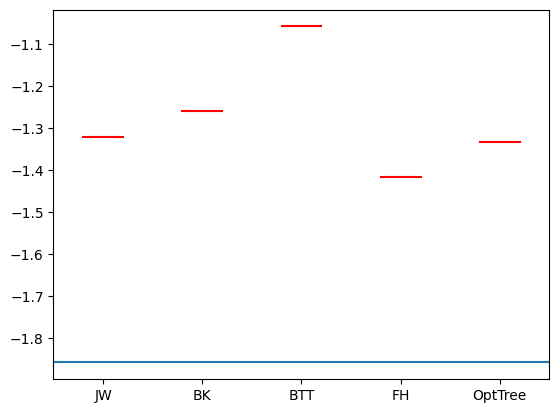

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

jw = ("JW", -1.3209011193140847, 0.3117595321527502)
bk = ("BK", -1.2588759249221313, 0.43528868011844934)
btt = ("BTT", -1.0589417409162922, 0.1347010014665952)
fh = ("FH", -1.4167123485497235, 0.3222858718976118)
opttree = ("OptTree", -1.3326066364085893, 0.35421429872540877)

THEO = -1.857275030202381


for n, (mapper, exp, var) in enumerate((jw, bk, btt, fh, opttree)):
    plt.plot([n - 0.2, n + 0.2], [exp, exp], color="red")

plt.xlim(0 - 0.5, 4 + 0.5)
plt.xticks([0, 1, 2, 3, 4], ["JW", "BK", "BTT", "FH", "OptTree"])

plt.plot([-1, 5], [THEO, THEO])

plt.show()